# 3.6 Regression

## 3.6.1 Load Dataset

In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets)= boston_housing.load_data()

2023-03-06 03:11:06.043895: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


57026/57026 [==============================] - 0s 1us/step


In [3]:
# look at the train and test data shapes
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [5]:
# The targets contain median home values
print(train_targets[0])

15.2


## 3.6.2 Normalize the Data

In [6]:
mean = train_data.mean(axis=0) # get training data mean for each feature
train_data -= mean # subtract mean from each feature
std = train_data.std(axis=0) # get training data stdev for each feature
train_data /= std # divide by stdev
test_data -= mean # do the same for test data using the training data's mean and stdev.
test_data /= std

## 3.6.3 Build the Network

In [7]:
# Because the dataset is small, use a small network with two hidden layers, each with 64 neurons
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation='relu',
    input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # model ends with a single unit and no activation (linear layer)
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) # loss pred. with mean squared error
    
    return model

## 3.6.4 Validate Approach using k-Fold

In [8]:
# dataset is too small to reliably use a validation set
# instead use k-fold validation
# train on k-1 partitions, and test on the remaining partition
# take an average of the final validation scores for each fold

import numpy as np

k=4
num_val_samples = len(train_data) // k # double slash is integer division, get the size of validation set
num_epochs = 100
all_scores = [] # append the validation fold scores here

for i in range(k):
    print('processing fold #', i)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] # set aside the validation fold training points
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] # set aside the validation fold target points
    
    # set aside the training data from all other partitions
    partial_train_data = np.concatenate( 
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0
    )
    
    # set aside target data from all other partitions
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0
    )
    
    model = build_model()
    
    model.fit(
        partial_train_data, partial_train_targets,
        epochs=num_epochs, batch_size=1, verbose=0
    )
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
print(all_scores)

[2.3024468421936035, 2.5673975944519043, 2.513744592666626, 2.408510446548462]


In [10]:
# predictions off by about $2500.

In [14]:
# retrain using 500 epochs and saving validation logs
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0
    )
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0
    )
    
    model = build_model()
    
    history = model.fit(
        partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history) # save the validation mae's here

processing fold # 0
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
processing fold # 1
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
processing fold # 2
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
processing fold # 3
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [15]:
# find the average mae
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

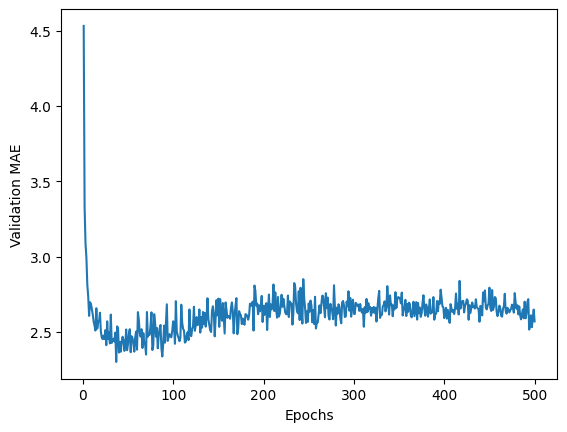

In [16]:
# plot validation scores
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

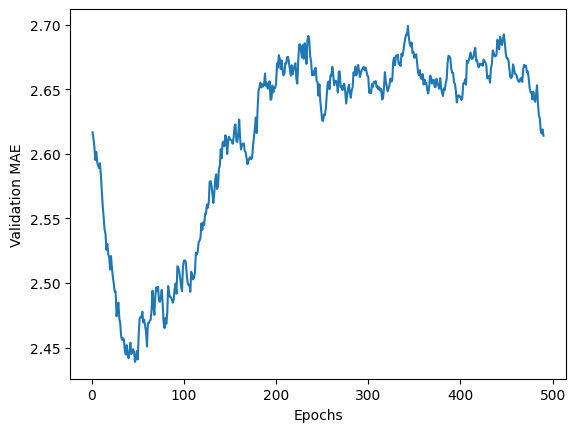

In [17]:
# exclude the first ten datapoints
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [18]:
# it looks like 80 epochs is the best number

In [19]:
# train new model
model = build_model()
model.fit(
    train_data, train_targets,
    epochs=80, batch_size=16, verbose=0
)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 19.0559 - mae: 2.7882


In [20]:
print(test_mae_score)

2.78818941116333


In [24]:
# still off by $2700. Which is worse performance that the original with 100 epochs.